### Set Up PySpark Environment

In [28]:
# from pyspark.sql import SparkSession

# # Create Spark session
# spark = SparkSession.builder \
#     .appName("Heart Attack Prediction Project") \
#     .getOrCreate()


# Dataset Loading

In [29]:

# file_path = "heart_attack_prediction_indonesia (1).csv"
# df = spark.read.csv(file_path, header=True, inferSchema=True)

# df.show(5)


In [31]:
# df.printSchema()


### Exploratory Data Analysis (EDA)

In [32]:
# print("Total Rows:", df.count())
# print("Total Columns:", len(df.columns))


In [33]:
# from pyspark.sql.functions import col, isnan, when, count

# # Count nulls and NaNs per column
# df.select([count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in df.columns]).show()


In [34]:
# df.groupBy("heart_attack").count().show()


In [36]:
# df.describe(["age", "cholesterol_hdl", "cholesterol_ldl", "triglycerides", "sleep_hours"]).show()


In [37]:
# df_sample = df.sample(False, 0.1, seed=1).toPandas()

In [38]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# sns.histplot(data=df_sample, x="age", hue="heart_attack", kde=True)
# plt.title("Age Distribution by Heart Attack Risk")
# plt.show()

### Data Preprocessing

In [39]:
# from pyspark.sql.functions import col

# numeric_columns = [
#     "cholesterol_hdl", "cholesterol_ldl", "triglycerides",
#     "sleep_hours", "blood_pressure_systolic", "blood_pressure_diastolic"
# ]

# # Convert to float
# for col_name in numeric_columns:
#     df = df.withColumn(col_name, col(col_name).cast("float"))

In [40]:
# from pyspark.ml.feature import StringIndexer

# categorical_cols = [
#     "gender", "region", "income_level", "cholesterol_level", "obesity",
#     "waist_circumference", "family_history", "smoking_status", "alcohol_consumption",
#     "physical_activity", "dietary_habits", "air_pollution_exposure",
#     "stress_level", "EKG_results", "previous_heart_disease", "medication_usage",
#     "participated_in_free_screening"
# ]

# # Index each column
# indexers = [StringIndexer(inputCol=col, outputCol=col+"_idx") for col in categorical_cols]


#### Targeet Variable Encoding 

In [41]:
# label_indexer = StringIndexer(inputCol="heart_attack", outputCol="label")


#### Assemble Features 

In [42]:
# from pyspark.ml.feature import VectorAssembler

# numeric_cols = [
#     "age", "cholesterol_hdl", "cholesterol_ldl", "triglycerides",
#     "sleep_hours", "blood_pressure_systolic", "blood_pressure_diastolic",
#     "hypertension", "diabetes", "fasting_blood_sugar"
# ]

# # Combine indexed categorical + numeric
# final_features = numeric_cols + [col + "_idx" for col in categorical_cols]

# assembler = VectorAssembler(inputCols=final_features, outputCol="features")


##### Pipeline 

In [43]:
# from pyspark.ml import Pipeline

# pipeline = Pipeline(stages=indexers + [label_indexer, assembler])
# model = pipeline.fit(df)
# df_prepared = model.transform(df)


#### Standardization

In [44]:
# from pyspark.ml.feature import StandardScaler

# scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
# scaler_model = scaler.fit(df_prepared)
# df_scaled = scaler_model.transform(df_prepared)


#### PCA

In [45]:
# from pyspark.ml.feature import PCA

# pca = PCA(k=10, inputCol="scaledFeatures", outputCol="pcaFeatures")
# pca_model = pca.fit(df_scaled)
# df_pca = pca_model.transform(df_scaled)


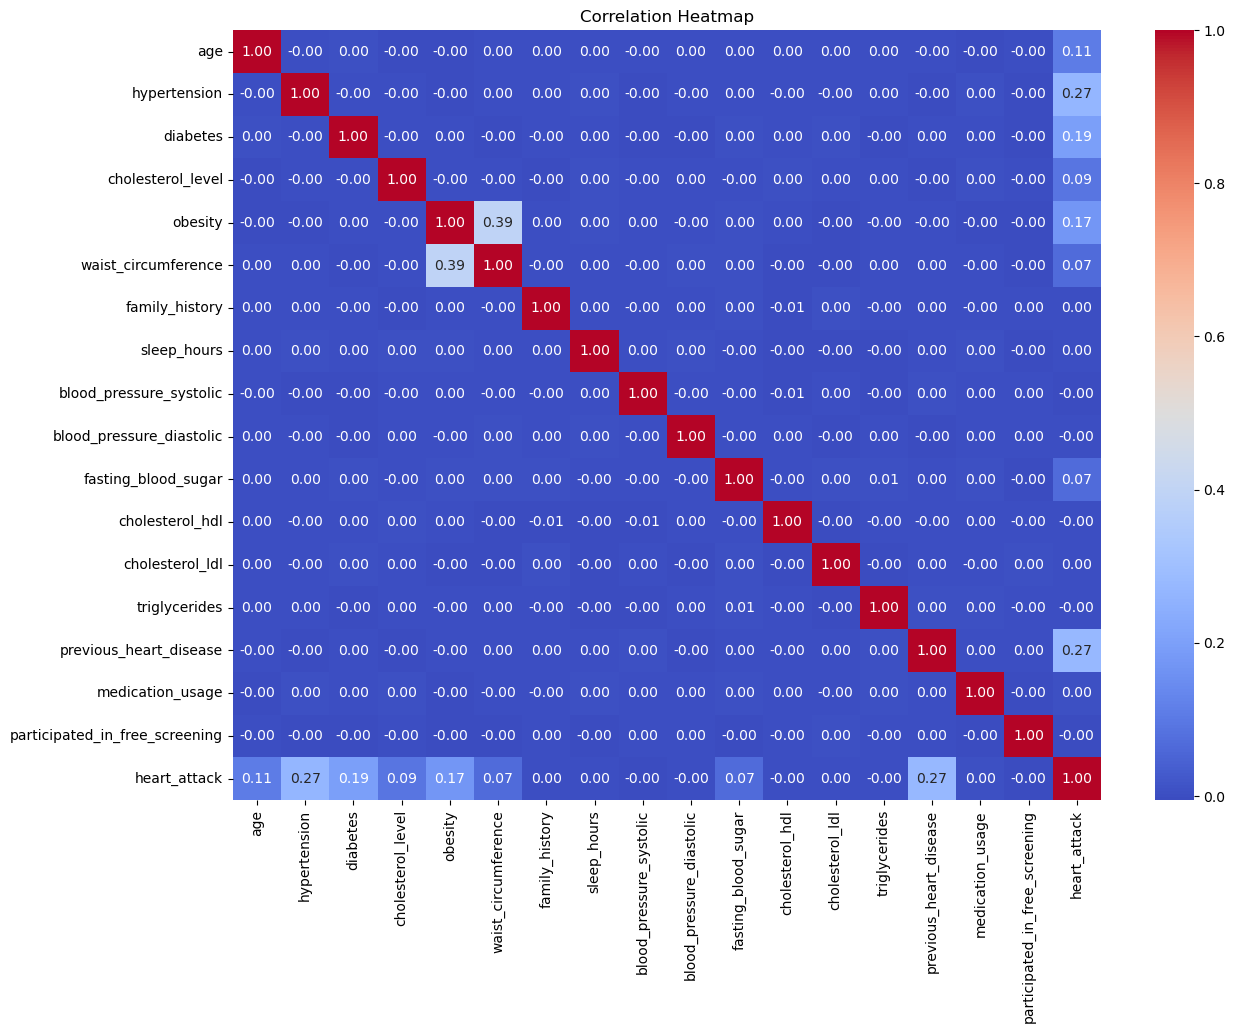

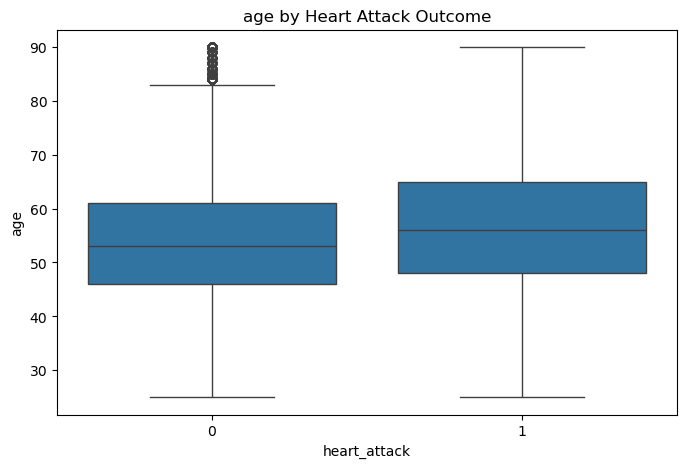

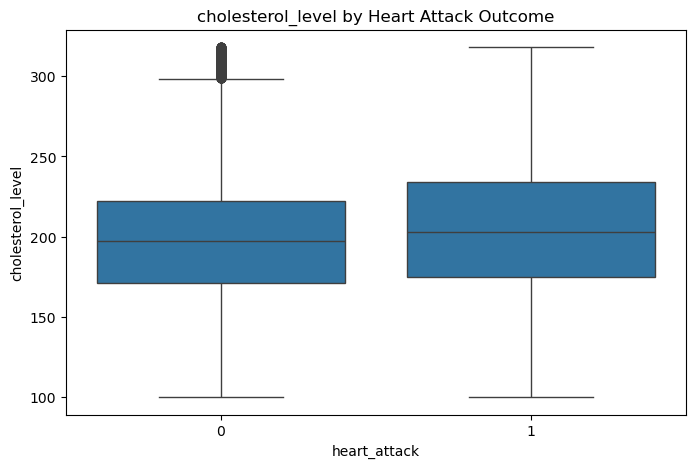

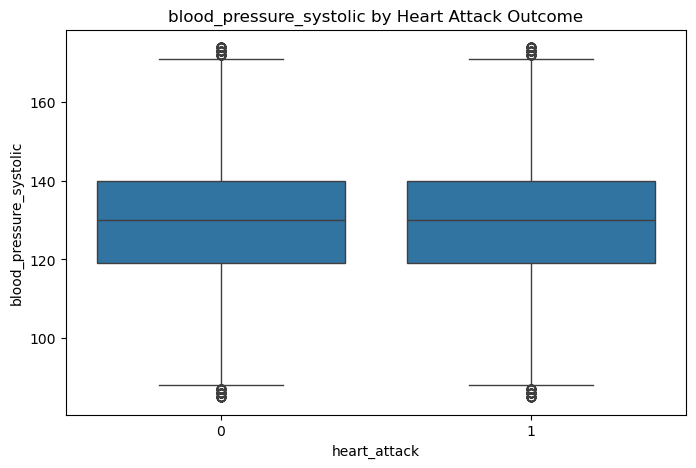

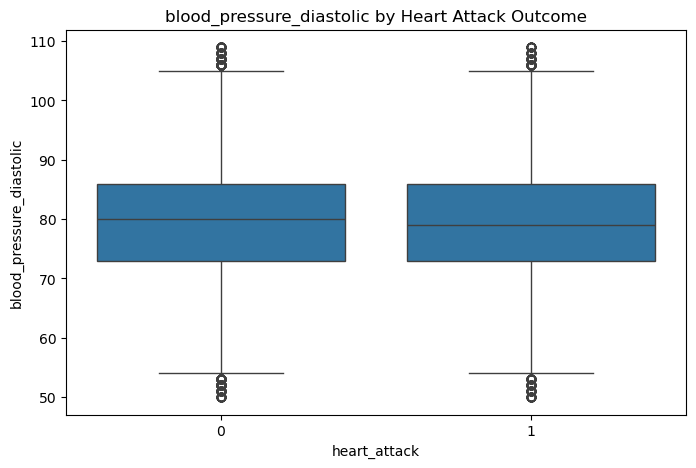

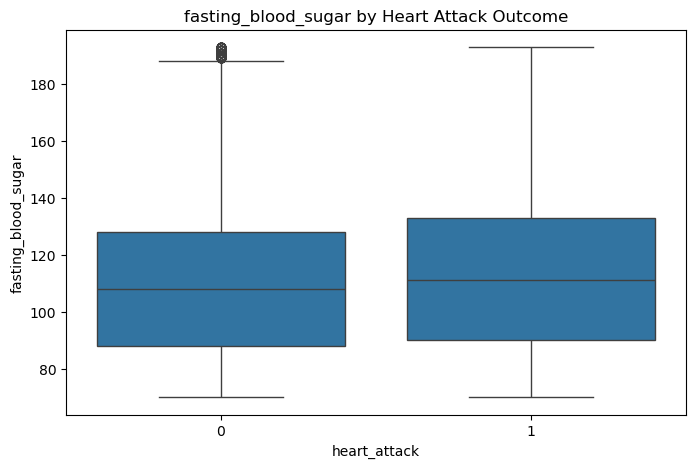

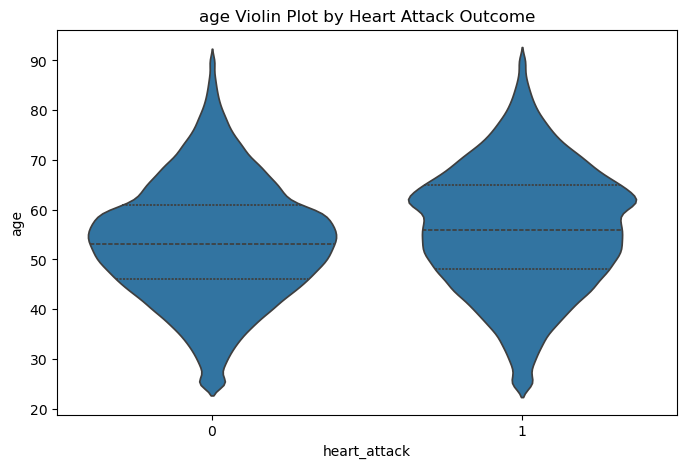

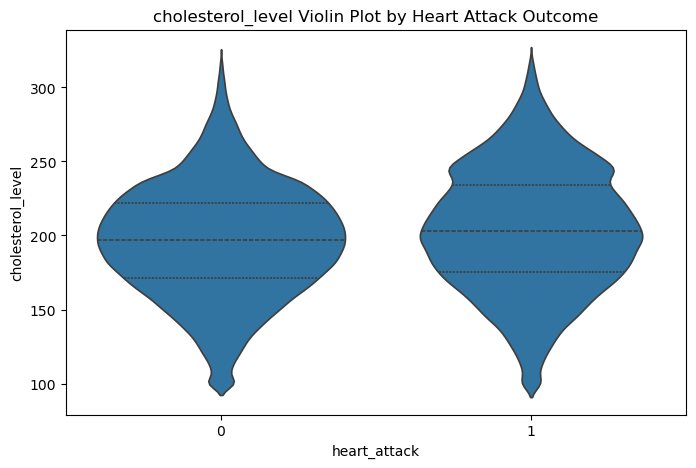

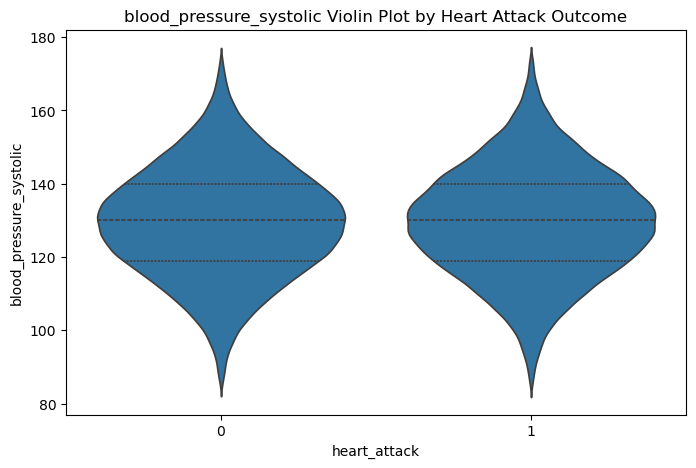

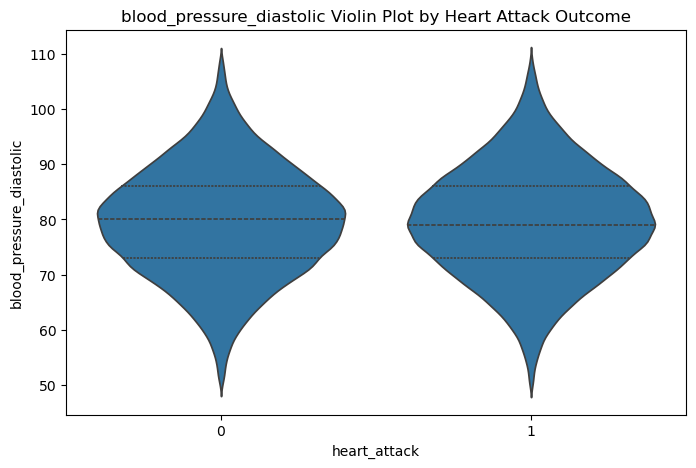

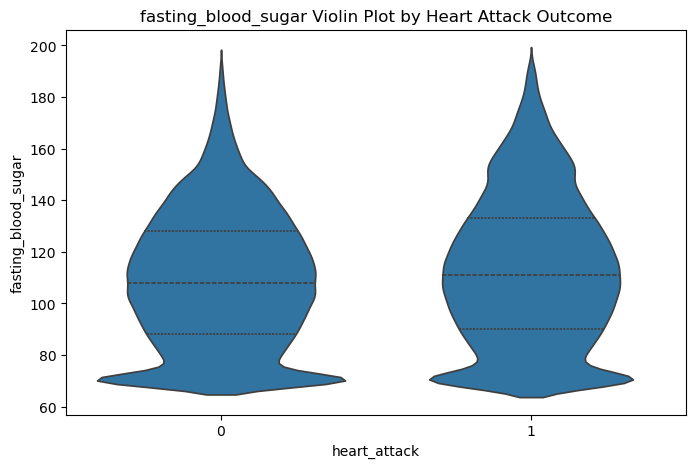

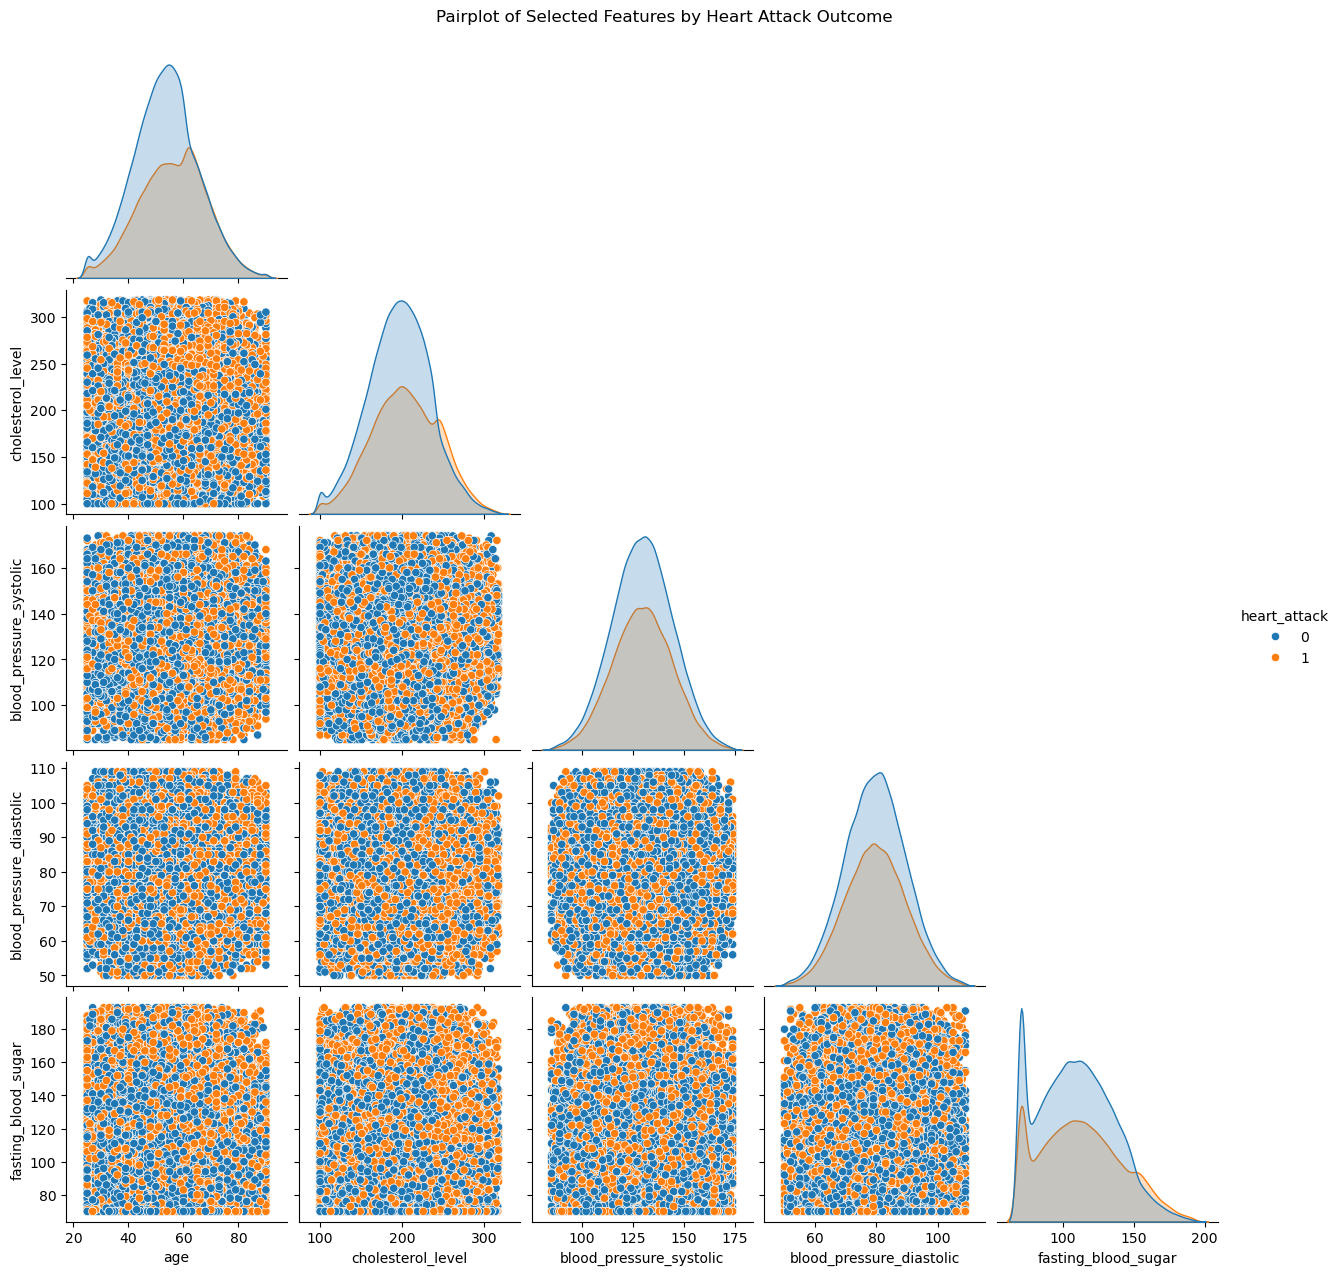

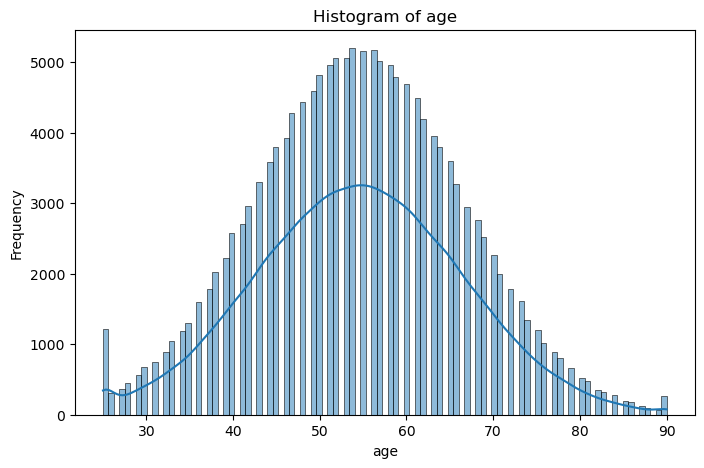

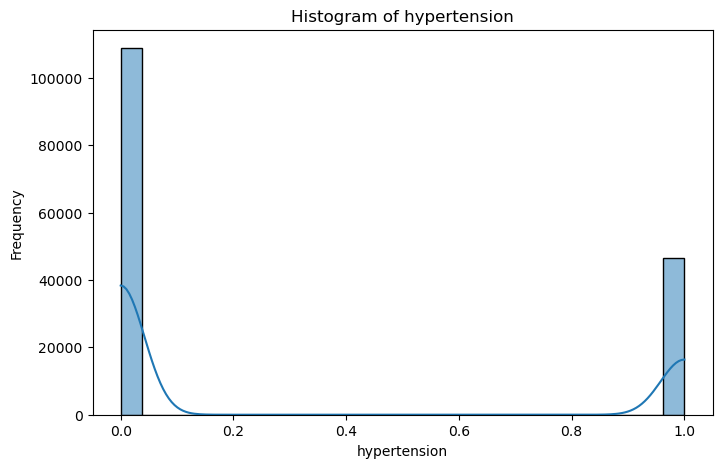

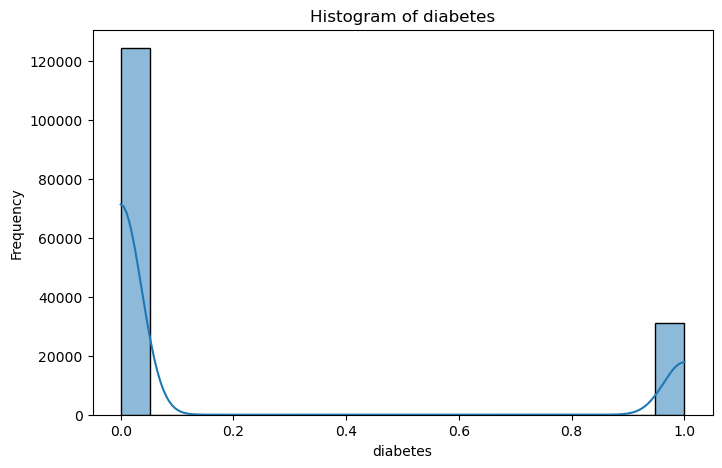

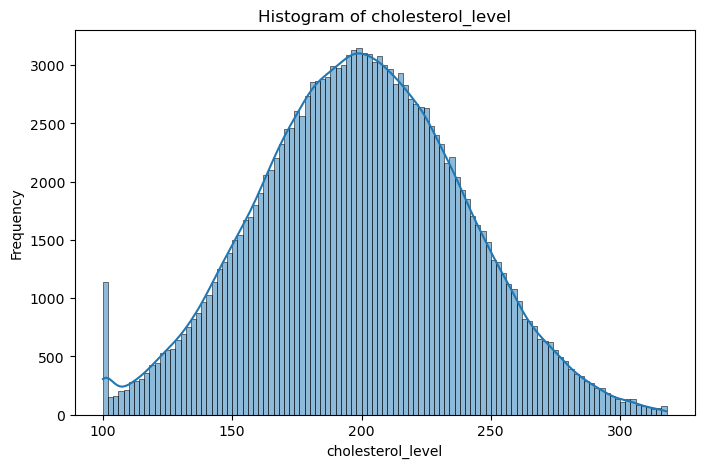

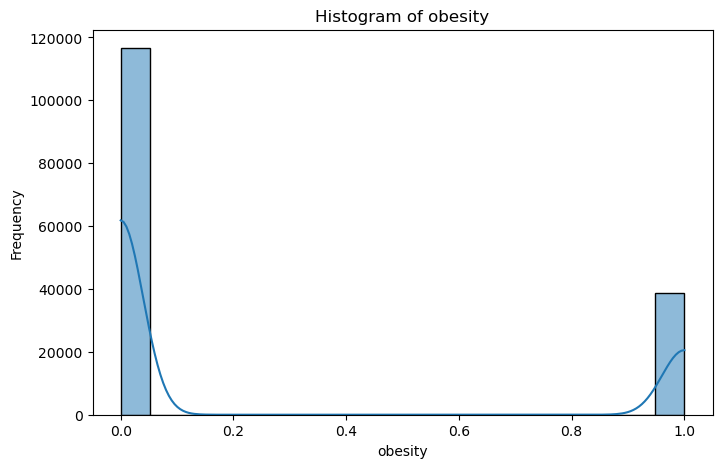

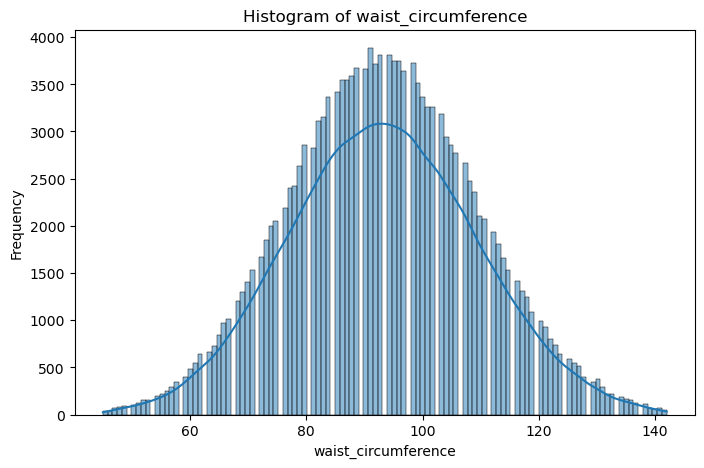

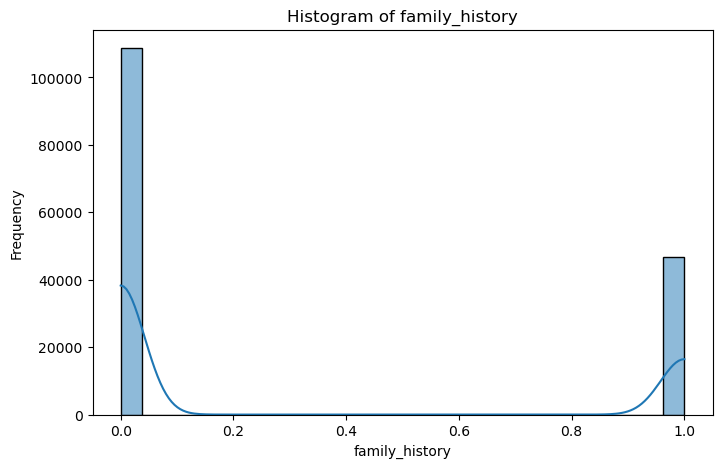

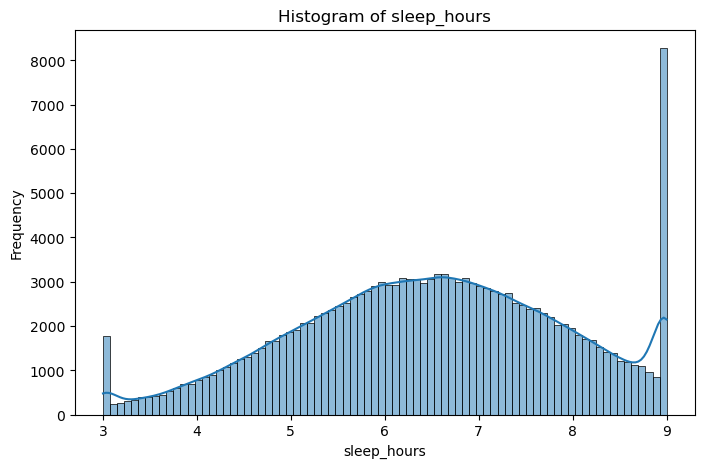

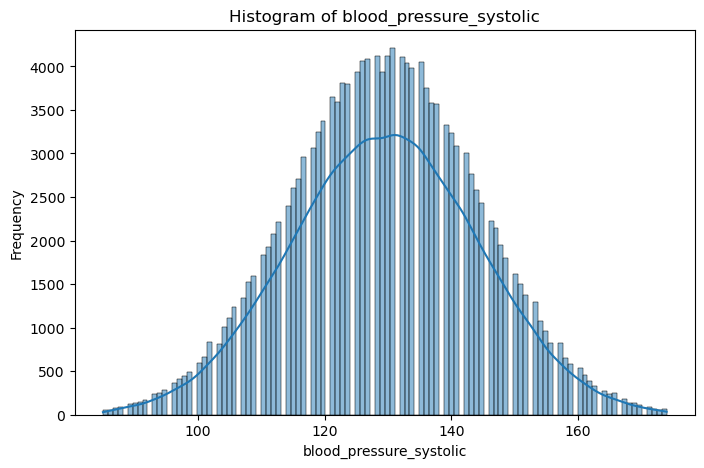

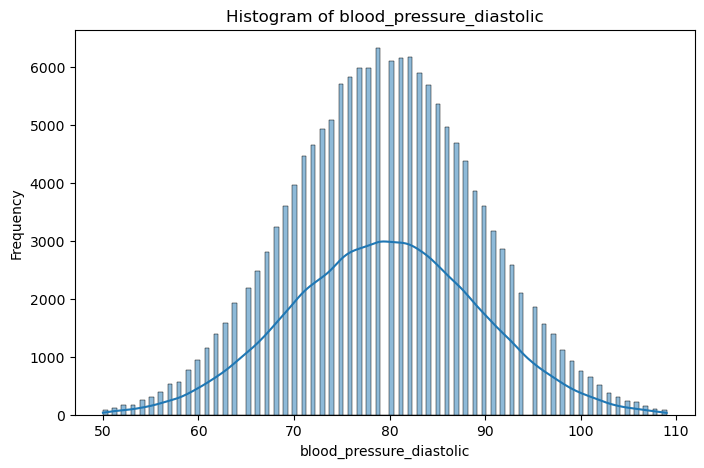

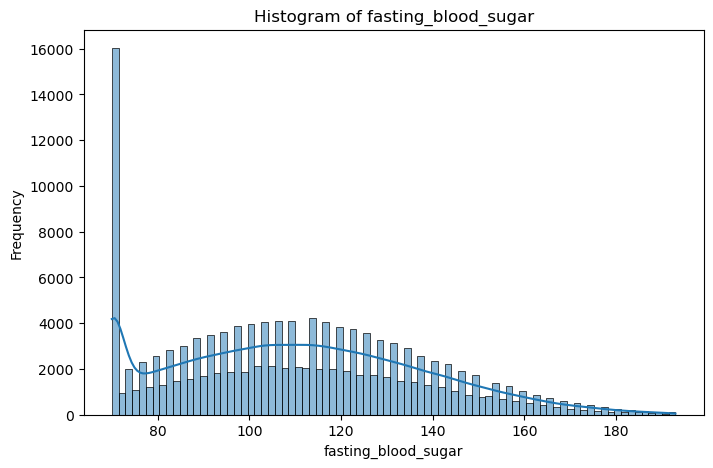

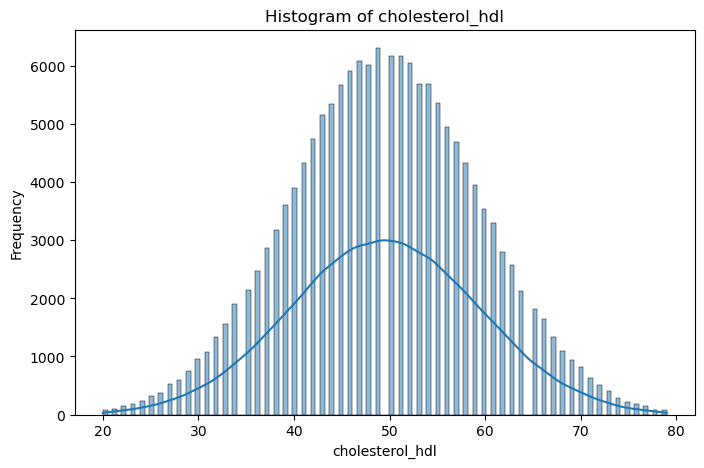

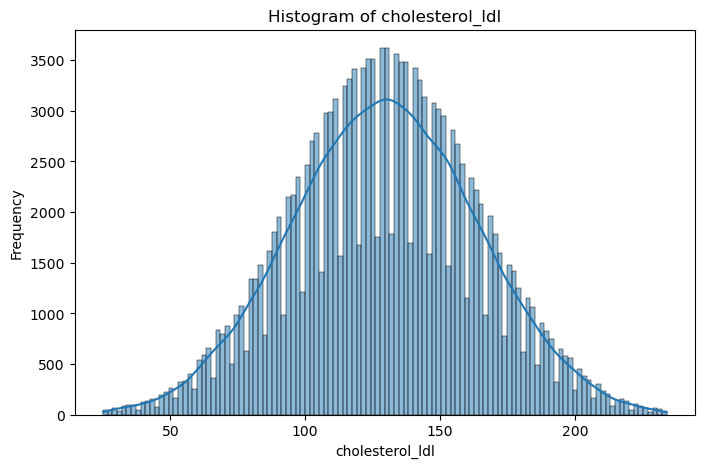

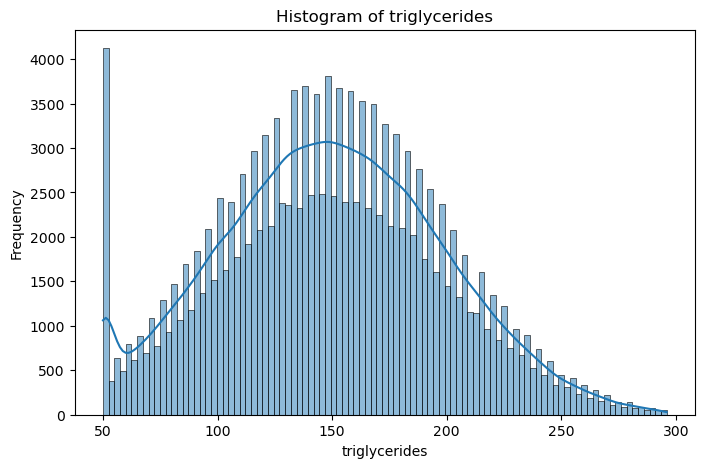

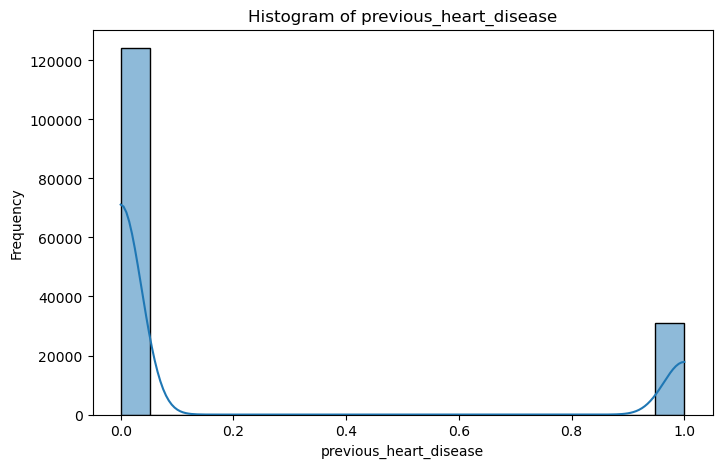

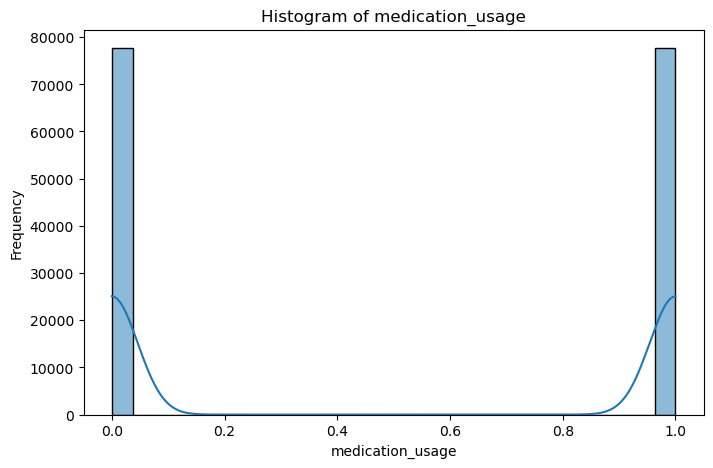

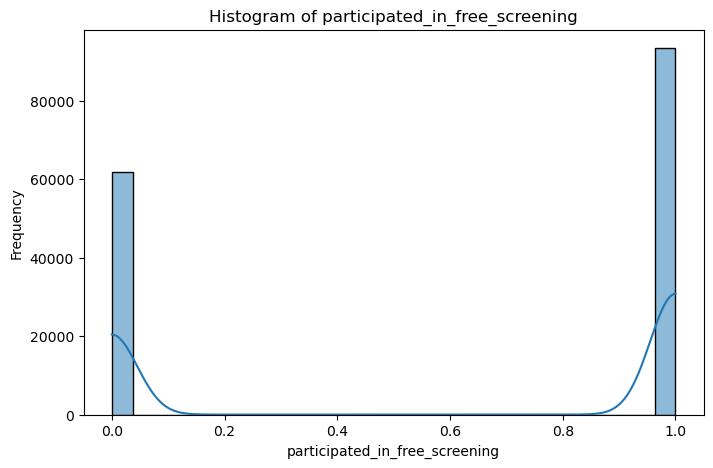

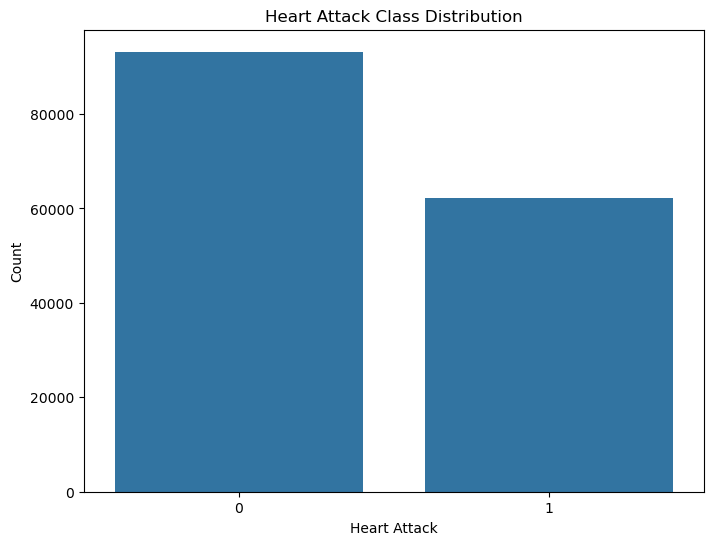

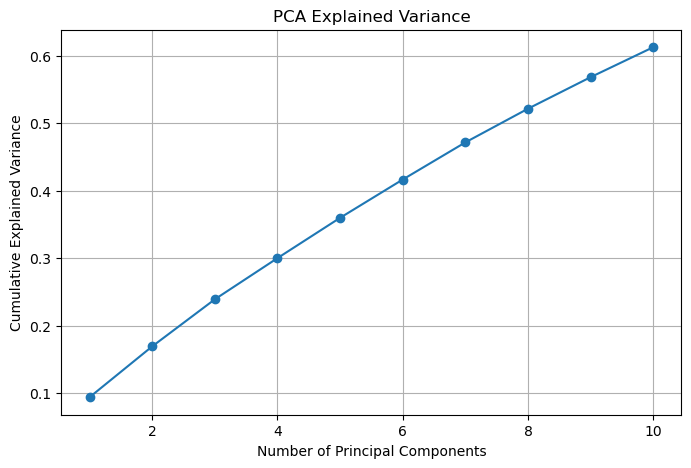

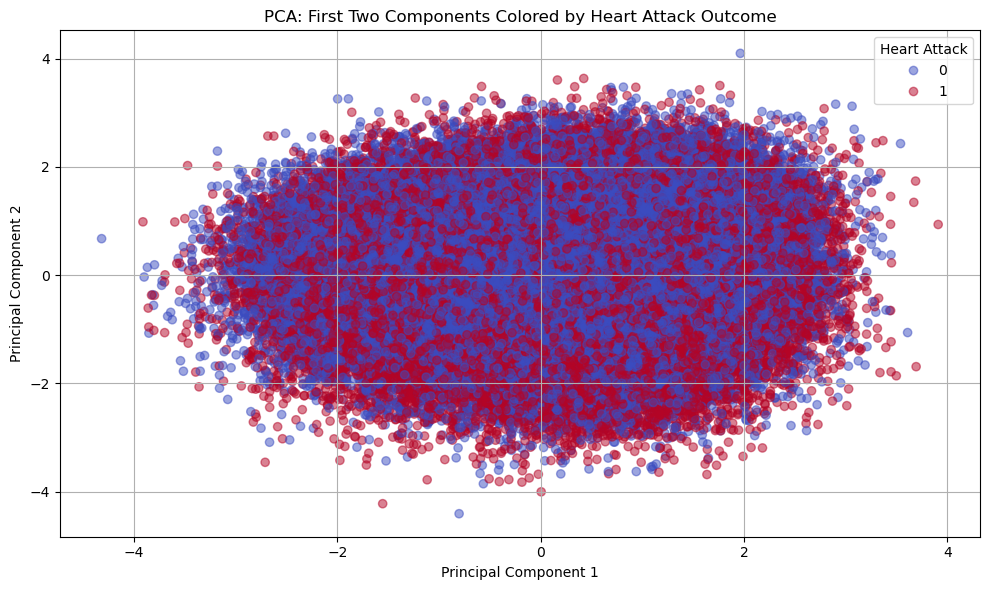

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, abs as ps_abs, udf
from pyspark.sql.types import DoubleType, IntegerType, LongType, StringType, NumericType, FloatType

from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, OneHotEncoder, PCA
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

spark = SparkSession.builder.appName("HeartAttackPrediction").getOrCreate()
file_path = "heart_attack_prediction_indonesia (1).csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Filter rows with non-negative cholesterol_ldl
df_cleaned = df.filter(col("cholesterol_ldl") >= 0)

# Identify numeric and categorical columns
numeric_cols = [field.name for field in df_cleaned.schema.fields 
                if isinstance(field.dataType, NumericType) and field.name != "heart_attack"]
categorical_cols = [field.name for field in df_cleaned.schema.fields 
                    if isinstance(field.dataType, StringType)]

# Outlier removal using z-score for each numeric column
for col_name in numeric_cols:
    stats = df_cleaned.selectExpr(f"avg({col_name}) as mean", f"stddev({col_name}) as std").collect()[0]
    mean_val = stats["mean"]
    std_val = stats["std"]
    if std_val and std_val != 0:
        df_cleaned = df_cleaned.filter(ps_abs(col(col_name) - mean_val) / std_val < 3)

# Convert cleaned Spark DataFrame to Pandas for plotting
pdf_cleaned = df_cleaned.toPandas()

# Correlation Heatmap (numeric features + target)
pdf_corr = pdf_cleaned[numeric_cols + ['heart_attack']]
plt.figure(figsize=(14, 10))
sns.heatmap(pdf_corr.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

# Selected features for plots
selected_features = ['age', 'cholesterol_level', 'blood_pressure_systolic', 
                     'blood_pressure_diastolic', 'fasting_blood_sugar']
pdf_features = df_cleaned.select(selected_features + ['heart_attack']).toPandas()

# Boxplots 
for feature in selected_features:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='heart_attack', y=feature, data=pdf_features)
    plt.title(f'{feature} by Heart Attack Outcome')
    plt.show()

# Violin Plots 
for feature in selected_features:
    plt.figure(figsize=(8, 5))
    sns.violinplot(x='heart_attack', y=feature, data=pdf_features, inner='quartile')
    plt.title(f'{feature} Violin Plot by Heart Attack Outcome')
    plt.show()

# Pairplot for selected features
sns.pairplot(pdf_features, hue='heart_attack', corner=True)
plt.suptitle('Pairplot of Selected Features by Heart Attack Outcome', y=1.02)
plt.show()

# Histograms
for col_name in numeric_cols:
    plt.figure(figsize=(8, 5))
    sns.histplot(pdf_cleaned[col_name], kde=True)
    plt.title(f'Histogram of {col_name}')
    plt.xlabel(col_name)
    plt.ylabel('Frequency')
    plt.show()

# Count Plot 
pdf_count = df_cleaned.select("heart_attack").toPandas()
plt.figure(figsize=(8, 6))
sns.countplot(x='heart_attack', data=pdf_count)
plt.title('Heart Attack Class Distribution')
plt.xlabel('Heart Attack')
plt.ylabel('Count')
plt.show()

# Build ML Pipeline 
stages = []

# Process categorical variables: StringIndexer and OneHotEncoder
for c in categorical_cols:
    indexer = StringIndexer(inputCol=c, outputCol=c + "_indexed", handleInvalid="keep")
    encoder = OneHotEncoder(inputCols=[c + "_indexed"], outputCols=[c + "_ohe"])
    stages += [indexer, encoder]

# Assemble numeric features
assembler_numeric = VectorAssembler(inputCols=numeric_cols, outputCol="numeric_features")
stages.append(assembler_numeric)

# Scale numeric features
scaler = StandardScaler(inputCol="numeric_features", outputCol="scaled_numeric_features", withMean=True, withStd=True)
stages.append(scaler)

# Assemble all features 
feature_cols = ["scaled_numeric_features"] + [c + "_ohe" for c in categorical_cols]
assembler_all = VectorAssembler(inputCols=feature_cols, outputCol="features")
stages.append(assembler_all)

# Apply PCA 
pca = PCA(k=10, inputCol="features", outputCol="pca_features")
stages.append(pca)

# Create and fit the pipeline on a small subset since it was not apprently handling whole data
pipeline = Pipeline(stages=stages)
df_sample = df_cleaned.limit(100)
pipeline_model = pipeline.fit(df_sample)
df_prepared = pipeline_model.transform(df_cleaned)

# Extract the first two PCA components using UDFs
extract_first = udf(lambda v: float(v[0]), FloatType())
extract_second = udf(lambda v: float(v[1]), FloatType())
df_plot = df_prepared.withColumn("pca1", extract_first("pca_features")) \
                     .withColumn("pca2", extract_second("pca_features"))

pdf_pca = df_plot.select("pca1", "pca2", "heart_attack").toPandas()
pdf_pca = pdf_pca.dropna(subset=['heart_attack'])

# PCA Explained Variance
explained_variance = pipeline_model.stages[-1].explainedVariance.toArray()
cumulative_explained = np.cumsum(explained_variance)
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(cumulative_explained) + 1), cumulative_explained, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()

# PCA Scatter Plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pdf_pca['pca1'], pdf_pca['pca2'], 
                      c=pdf_pca['heart_attack'].astype(int), cmap='coolwarm', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: First Two Components Colored by Heart Attack Outcome')
plt.legend(*scatter.legend_elements(), title="Heart Attack")
plt.grid(True)
plt.tight_layout()
plt.show()

#  Random Forest Model Training and Evaluation 
# Split the prepared data into training and testing sets -----> to be continued by Aleem
if "heart_attack_indexed" not in df_prepared.columns:
    label_indexer = StringIndexer(inputCol="heart_attack", outputCol="heart_attack_indexed")
    df_prepared = label_indexer.fit(df_prepared).transform(df_prepared)
train, test = df_prepared.randomSplit([0.8, 0.2], seed=42)


In [69]:

pca_model = pipeline_model.stages[-1]  

# Get number of components
print("Number of PCA components used:", pca_model.getK())


Number of PCA components used: 10


In [67]:

explained_variance = pca_model.explainedVariance.toArray()

# Sum of first 10 components
cumulative_variance_10 = sum(explained_variance[:10])

print(f"Cumulative variance of first 10 components: {cumulative_variance_10:.4f}")


Cumulative variance of first 10 components: 0.4548


In [65]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Define evaluators
evaluator_acc = MulticlassClassificationEvaluator(
    labelCol="heart_attack_indexed", predictionCol="prediction", metricName="accuracy"
)
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="heart_attack_indexed", predictionCol="prediction", metricName="f1"
)

# Train the model
rf = RandomForestClassifier(labelCol="heart_attack_indexed", featuresCol="pca_features", numTrees=100)
rf_model = rf.fit(train)

# Predict
rf_predictions = rf_model.transform(test)

# Evaluate
rf_accuracy = evaluator_acc.evaluate(rf_predictions)
rf_f1 = evaluator_f1.evaluate(rf_predictions)

print("=== Random Forest Evaluation ===")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"F1 Score: {rf_f1:.4f}")


=== Random Forest Evaluation ===
Accuracy: 0.8511
F1 Score: 0.8495


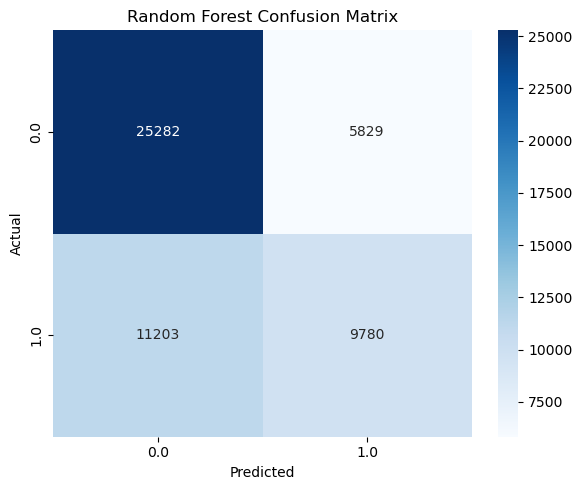

In [52]:
# Confusion Matrix Plot
rf_pred_pdf = rf_predictions.select("prediction", "heart_attack_indexed").toPandas()
cm = confusion_matrix(rf_pred_pdf["heart_attack_indexed"], rf_pred_pdf["prediction"])
labels = sorted(rf_pred_pdf["heart_attack_indexed"].unique())

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


=== Logistic Regression Evaluation ===
Accuracy: 0.6642
F1 Score: 0.6448


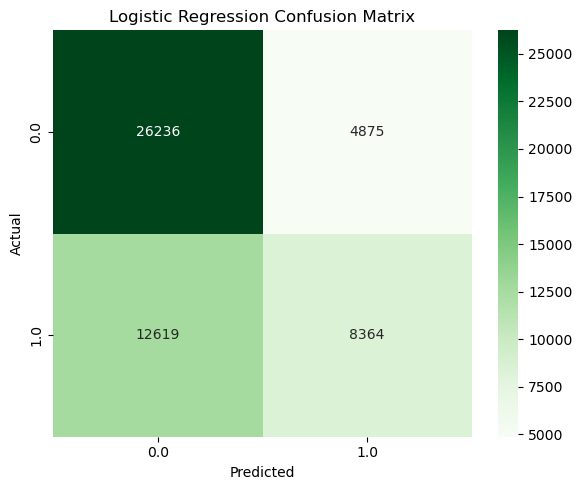

In [53]:
from pyspark.ml.classification import LogisticRegression

# Train Logistic Regression
lr = LogisticRegression(labelCol="heart_attack_indexed", featuresCol="pca_features", maxIter=100)
lr_model = lr.fit(train)

# Predict
lr_predictions = lr_model.transform(test)

# Evaluate
lr_accuracy = evaluator_acc.evaluate(lr_predictions)
lr_f1 = evaluator_f1.evaluate(lr_predictions)

print("=== Logistic Regression Evaluation ===")
print(f"Accuracy: {lr_accuracy:.4f}")
print(f"F1 Score: {lr_f1:.4f}")

# Confusion Matrix
lr_pred_pdf = lr_predictions.select("prediction", "heart_attack_indexed").toPandas()
cm = confusion_matrix(lr_pred_pdf["heart_attack_indexed"], lr_pred_pdf["prediction"])
labels = sorted(lr_pred_pdf["heart_attack_indexed"].unique())

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=labels, yticklabels=labels)
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


=== Gradient Boosted Trees Evaluation (Binary) ===
Accuracy: 0.6728
F1 Score: 0.6634


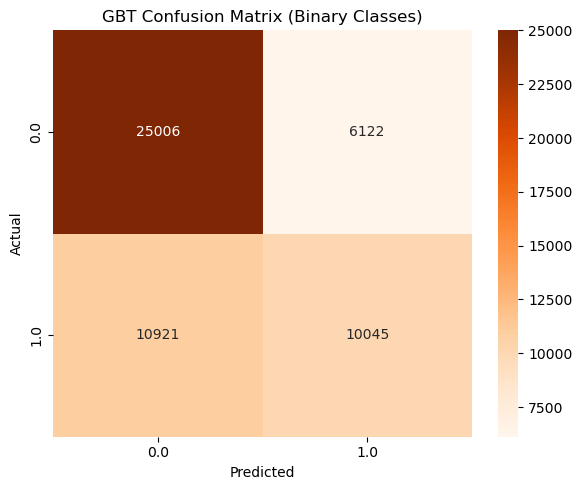

In [58]:
df_binary = df_prepared.filter(col("heart_attack_indexed").isin(0.0, 1.0))
train_bin, test_bin = df_binary.randomSplit([0.8, 0.2], seed=42)
from pyspark.ml.classification import GBTClassifier

# Train GBT only on binary data
gbt = GBTClassifier(labelCol="heart_attack_indexed", featuresCol="pca_features", maxIter=100)
gbt_model = gbt.fit(train_bin)

# Predict
gbt_predictions = gbt_model.transform(test_bin)

# Evaluate
gbt_accuracy = evaluator_acc.evaluate(gbt_predictions)
gbt_f1 = evaluator_f1.evaluate(gbt_predictions)

print("=== Gradient Boosted Trees Evaluation (Binary) ===")
print(f"Accuracy: {gbt_accuracy:.4f}")
print(f"F1 Score: {gbt_f1:.4f}")
gbt_pred_pdf = gbt_predictions.select("prediction", "heart_attack_indexed").toPandas()
cm = confusion_matrix(gbt_pred_pdf["heart_attack_indexed"], gbt_pred_pdf["prediction"])
labels = sorted(gbt_pred_pdf["heart_attack_indexed"].unique())

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", xticklabels=labels, yticklabels=labels)
plt.title("GBT Confusion Matrix (Binary Classes)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()
